# Exercise 1 - Toffoli gate
This notebook contains my solution to the first exercise of the IBM Quantum Challenge 2021. My final solution has a cost of 72, but along the way I was able to construct a Toffoli gate with some phase difference with a cost of 70. My name is Emilio Peláez and my GitHub profile is [@epelaaez](https://github.com/epelaaez) if you want to check it out!

### Imports
The next cell imports everything needed for this notebook.

In [3]:
from qiskit import QuantumCircuit, execute, BasicAer, Aer, IBMQ, QuantumRegister, ClassicalRegister
from qiskit.compiler import transpile, assemble
import numpy as np
from sympy import Matrix

### Helper functions
I defined two functions to help get to my solution. First, one that prints the unitary matrix corresponding to my circuit. It is defined as follows.

In [4]:
def unitary(circ):
    backend = BasicAer.get_backend('unitary_simulator')
    out = execute(circ, backend).result().get_unitary()
    display(Matrix(np.round(out, 10))) 

And the other function gets the cost of my circuit as defined in the problem notebook.

In [101]:
def cost(circ):
    circ = transpile(circ, basis_gates= ['rz', 'sx', 'x', 'cx'], optimization_level=3)
    gates = circ.count_ops()

    try:
        no_rz = gates['rz']
    except:
        no_rz = 0
    try:
        no_sx = gates['sx']
    except:
        no_sx = 0
    try:
        no_x = gates['x']
    except:
        no_x = 0
    try:
        no_cx = gates['cx']
    except:
        no_cx = 0
    cost = no_rz + no_sx + no_x + 10*no_cx
    
    print(cost)

### Solution
First, I'll describe how I tried to get a cost 70 solution. To do this, first I got the unitary for a normal Toffoli gate to work from there.

In [102]:
qc = QuantumCircuit(3)
qc.ccx(0, 1, 2)
unitary(qc)

Matrix([
[1.0,   0,   0,   0,   0,   0,   0,   0],
[  0, 1.0,   0,   0,   0,   0,   0,   0],
[  0,   0, 1.0,   0,   0,   0,   0,   0],
[  0,   0,   0,   0,   0,   0,   0, 1.0],
[  0,   0,   0,   0, 1.0,   0,   0,   0],
[  0,   0,   0,   0,   0, 1.0,   0,   0],
[  0,   0,   0,   0,   0,   0, 1.0,   0],
[  0,   0,   0, 1.0,   0,   0,   0,   0]])

Then, I constructed the following circuit that resembles this matrix up to some phase difference. At this point, I already knew that the answer was probably going to get rejected because of this difference, but I still wanted to go ahead and try.

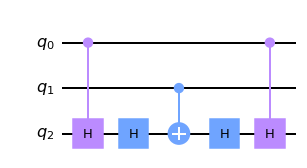

In [103]:
qc = QuantumCircuit(3)

qc.ch(0,2)
qc.h(2)
qc.cx(1,2)
qc.h(2)
qc.ch(0,2)

qc.draw('mpl')

In [104]:
unitary(qc)

Matrix([
[1.0,   0,   0,   0,   0,   0,    0,   0],
[  0, 1.0,   0,   0,   0,   0,    0,   0],
[  0,   0, 1.0,   0,   0,   0,    0,   0],
[  0,   0,   0,   0,   0,   0,    0, 1.0],
[  0,   0,   0,   0, 1.0,   0,    0,   0],
[  0,   0,   0,   0,   0, 1.0,    0,   0],
[  0,   0,   0,   0,   0,   0, -1.0,   0],
[  0,   0,   0, 1.0,   0,   0,    0,   0]])

As you can see, a phase difference of -1 can be seen in the (7,7) element of the matrix. To get this solution working, I had to write the circuit above only with the gates allowed. Building the Hadamard gate was easy since it was already given in the tutorial part of the notebook.

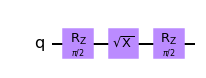

In [105]:
def hadamard(qc, target):
    qc.rz(np.pi/2, target)
    qc.sx(target)
    qc.rz(np.pi/2, target)
    
qc = QuantumCircuit(1)
hadamard(qc, 0)
qc.draw('mpl')

In [106]:
unitary(qc)

Matrix([
[0.5 - 0.5*I,  0.5 - 0.5*I],
[0.5 - 0.5*I, -0.5 + 0.5*I]])

The matrix for this gate doesn't seem completely right. Let's look at the matrix for a normal Hadamard gate to compare it.

In [107]:
qc = QuantumCircuit(1)
qc.h(0)
unitary(qc)

Matrix([
[0.7071067812,  0.7071067812],
[0.7071067812, -0.7071067812]])

As you can see, the matrices are indeed different. However, this is only a phase difference. You can see this by comparing the norm of each element between the two matrices, they are all equal to $1/\sqrt{2}$. Now, we are only missing to build a controlled Hadamard gate with the allowed gates. 

Doing this was mostly a matter of playing around with different rotations while imagining their effect on the Bloch sphere. Another important thing was that we needed to introduce some controlled gate, the only one allowed being CX. And while introducing this gate we had to be careful that the overall effect when the control qubit was set to 0 was equal to the identity. After some thought, this was the result.

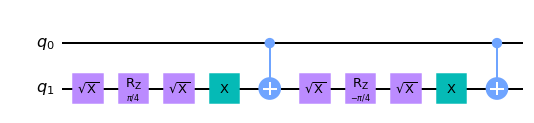

In [108]:
def c_hadamard(qc, control, target):
    # Ry pi/4
    qc.sx(target)
    qc.rz(np.pi/4, target)
    qc.sx(target)
    qc.x(target)

    qc.cx(control,target)

    # Ry -pi/4
    qc.sx(target)
    qc.rz(-np.pi/4, target)
    qc.sx(target)
    qc.x(target)

    qc.cx(control,target)
    
    return qc

qc = QuantumCircuit(2)
c_hadamard(qc, 0, 1)
qc.draw('mpl')

In [109]:
unitary(qc)

Matrix([
[1.0,            0,   0,             0],
[  0, 0.7071067812,   0, -0.7071067812],
[  0,            0, 1.0,             0],
[  0, 0.7071067812,   0,  0.7071067812]])

And we compare it with the normal controlled Hadamard gate.

In [110]:
qc = QuantumCircuit(2)
qc.ch(0,1)
unitary(qc)

Matrix([
[1.0,            0,   0,             0],
[  0, 0.7071067812,   0,  0.7071067812],
[  0,            0, 1.0,             0],
[  0, 0.7071067812,   0, -0.7071067812]])

As you can see, this gate again introduces some more phase difference, this case in two elements of the matrix. Finally, we also had to defined the inverse of the controlled Hadamard gate. This is because in the original circuit the second controlled Hadamard gate serves the purpose of being the dagger of the first controlled Hadamard. The original controlled Hadamard is its own inverse, but in our implementation we had to change the order of the R$_y$ rotations to make them inverses of each other.

In [111]:
def c_hadamard_dag(qc, control, target):
    # Ry -pi/4
    qc.sx(target)
    qc.rz(-np.pi/4, target)
    qc.sx(target)
    qc.x(target)

    qc.cx(control,target)

    # Ry pi/4
    qc.sx(target)
    qc.rz(np.pi/4, target)
    qc.sx(target)
    qc.x(target)

    qc.cx(control,target)
    
    return qc

Now, we can build the circuit we showed first using the new functions we defined that ensure we only used the gates allowed by the challenge.

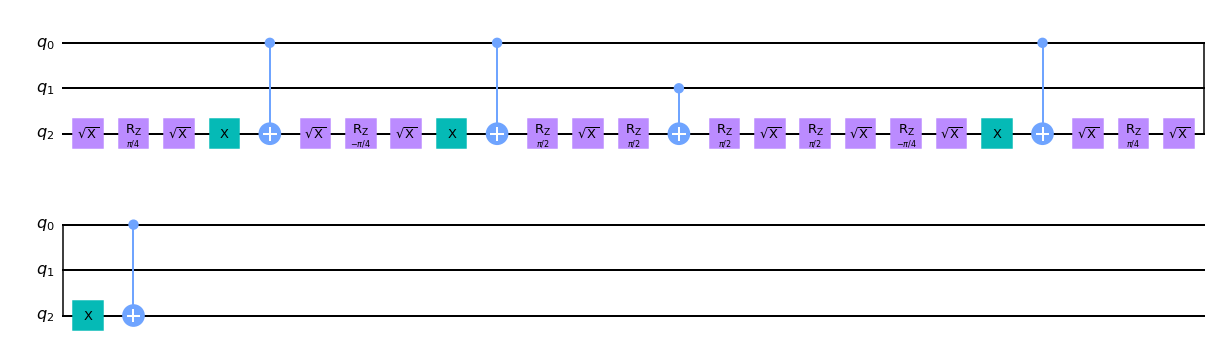

In [112]:
circuit = QuantumCircuit(3)

c_hadamard(circuit, 0, 2)
hadamard(circuit, 2)
circuit.cx(1, 2)
hadamard(circuit, 2)
c_hadamard_dag(circuit, 0, 2)

circuit.draw(output='mpl')

In [113]:
unitary(circuit)
cost(circuit)

Matrix([
[-1.0*I,      0,      0,     0,      0,      0,     0,     0],
[     0, -1.0*I,      0,     0,      0,      0,     0,     0],
[     0,      0, -1.0*I,     0,      0,      0,     0,     0],
[     0,      0,      0,     0,      0,      0,     0, 1.0*I],
[     0,      0,      0,     0, -1.0*I,      0,     0,     0],
[     0,      0,      0,     0,      0, -1.0*I,     0,     0],
[     0,      0,      0,     0,      0,      0, 1.0*I,     0],
[     0,      0,      0, 1.0*I,      0,      0,     0,     0]])

70


As you can see, this circuit gives us the desired matrix (up to some phase difference) with cost 70. We see even more phase difference than the first time we built this circuit because the implementation of each gate added some more phase difference. As I said before, this solution is not accepted because of this, but it could be useful for some speciric cases in which you don't care about phase.

Now, for the actual solution I submitted. I just went ahead and build the Toffoli gate the same way the unroller does. This solution may not be the most clever but I spend a lot of time building the pseudo-solution above and I wanted to move on with other exercises.

72


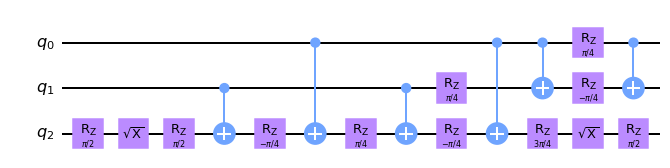

In [116]:
circ = QuantumCircuit(3)

circ.rz(np.pi/2, 2)
circ.sx(2)
circ.rz(np.pi/2, 2)
circ.cx(1, 2)
circ.rz(-np.pi/4, 2)
circ.cx(0, 2)
circ.rz(np.pi/4, 2)
circ.cx(1, 2)
circ.rz(np.pi/4, 1)
circ.rz(-np.pi/4, 2)
circ.cx(0, 2)
circ.cx(0, 1)
circ.rz(3*np.pi/4, 2)
circ.rz(np.pi/4, 0)
circ.rz(-np.pi/4, 1)
circ.sx(2)
circ.cx(0, 1)
circ.rz(np.pi/2, 2)

cost(circ)
circ.draw(output='mpl')

In [118]:
unitary(circ)

Matrix([
[-0.3826834324 - 0.9238795325*I,                              0,                              0,                              0,                              0,                              0,                              0,                              0],
[                             0, -0.3826834324 - 0.9238795325*I,                              0,                              0,                              0,                              0,                              0,                              0],
[                             0,                              0, -0.3826834324 - 0.9238795325*I,                              0,                              0,                              0,                              0,                              0],
[                             0,                              0,                              0,                              0,                              0,                              0,                         

And eventhough the matrix for this circuit is not the exact same as the one of the normal Toffoli gate, the phase difference introduced is the same for each element of the matrix (which is not true in my first attempt) and therefore it can be considered a global difference and ignored.

And it is indeed ignored by the grader and thus the solution is correct.

In [120]:
from qc_grader import grade_ex1
grade_ex1(circ)

Grading your answer for ex1. Please wait...

Congratulations 🎉! Your answer is correct.
Your cost is 72.
Feel free to submit your answer.

